<a href="https://colab.research.google.com/github/cbishop4/MSE7530/blob/main/ClassNotebooks/Class_20251022_ellipsometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSE 7530 - Spectroscopic Ellipsometry, 10/22/2025  
Almost all of the code contained in this walkthrough is from https://refellips.readthedocs.io/en/main/getting_started.html  
<font color='red'> Caution: the units in this code ($\mu m$ vs. $nm$ vs. $Å$) are inconsistent; the program mentions this, but it must be this way due to the conventions by which most instruments report data. Pay close attention to length units.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
! pip install refnx
! pip install refellips

In [6]:
import sys
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import RI, Cauchy, load_material

Loading the Github for this project - necessary to get the example files needed.

In [7]:
! git clone https://github.com/refnx/refellips/

Cloning into 'refellips'...
remote: Enumerating objects: 1740, done.
remote: Counting objects: 100% (444/444), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 1740 (delta 317), reused 301 (delta 290), pack-reused 1296 (from 1)
Receiving objects: 100% (1740/1740), 4.19 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (1067/1067), done.


In [8]:
pth = os.path.dirname(refellips.__file__)
dname = "/content/refellips/demos/testData1_11nm_PNIPAM_on_Si_EP4.dat"
file_path = pjoin(pth, "../", "demos", dname)

<font size=5><font color='blue'>Goal: find the exact thickness of a film of PNIPAM on Silicon.

## Load the dataset

In [9]:
data = DataSE(data=file_path)

In [10]:
data

Data1D(data='/content/refellips/demos/testData1_11nm_PNIPAM_on_Si_EP4.dat', mask=None)

<font size=4> Let's examine our data.

In [ ]:
vars(data)

{'filename': '/content/refellips/demos/testData1_11nm_PNIPAM_on_Si_EP4.dat',
 'delimiter': '\t',
 'metadata': {},
 '_wavelength': array([658., 658., 658., 658.]),
 '_aoi': array([55., 60., 65., 70.]),
 '_psi': array([27.7 , 23.25, 17.8 , 11.7 ]),
 '_delta': array([170.2 , 166.35, 159.65, 143.9 ]),
 'weighted': False,
 'name': None,
 '_delta_flipped': False,
 'mask': array([ True,  True,  True,  True])}

Generally, when something has an underscore (_) in front of its variable, it means that the user typically shouldn't be accessing it (i.e, it's "under the hood" and exists primarily to be referenced by other functions). To be explicit about what we have here, though, let's plot the data:

Text(0.5, 0, 'Angle of Incidence (degrees)')

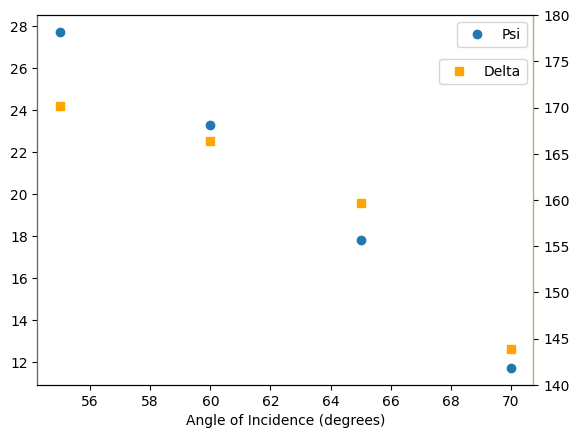

In [11]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(vars(data)['_aoi'],vars(data)['_psi'],'o',label='Psi')
ax2.plot(vars(data)['_aoi'],vars(data)['_delta'],'s',color='orange',label='Delta')

ax2.set_ylim(140,180)
ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,.9))
ax2.spines['left'].set_color('tab:blue')
ax2.spines['right'].set_color('orange')

ax1.set_xlabel('Angle of Incidence (degrees)')

## Set up all of the materials we will need.  
To model our PNIPAM film, we will need its Silicon substrate, a thermal SiO2 oxide that is found on silicon, PNIPAM optical constants, and air. They will be specified in different ways.

The first two are loaded with "load_material". They are specific materials that are already tabulated and exist within the refellips package.

In [12]:
si = load_material("silicon")

In [13]:
si

In [14]:
air = load_material("air")

In [15]:
air

In [16]:
vars(si)

{'name': '',
 'dispersive': True,
 'wavelength': 658,
 '_wav': array([206.6, 210.1, 213.8, 217.5, 221.4, 225.4, 229.6, 233.9, 238.4,
        243.1, 248. , 253. , 258.3, 263.8, 269.5, 275.5, 281.8, 288.3,
        295.2, 302.4, 310. , 317.9, 326.3, 335.1, 344.4, 354.2, 364.7,
        375.7, 387.5, 399.9, 413.3, 427.5, 442.8, 459.2, 476.9, 495.9,
        516.6, 539.1, 563.6, 590.4, 619.9, 652.5, 688.8, 729.3, 774.9,
        826.6]),
 '_RI': array([1.01 , 1.083, 1.133, 1.186, 1.247, 1.34 , 1.471, 1.579, 1.589,
        1.571, 1.57 , 1.597, 1.658, 1.764, 1.988, 2.452, 3.12 , 4.087,
        4.888, 5.02 , 5.01 , 5.016, 5.065, 5.156, 5.296, 5.61 , 6.522,
        6.709, 6.062, 5.57 , 5.222, 4.961, 4.753, 4.583, 4.442, 4.32 ,
        4.215, 4.123, 4.042, 3.969, 3.906, 3.847, 3.796, 3.752, 3.714,
        3.673]),
 '_EC': array([2.909e+00, 2.982e+00, 3.045e+00, 3.120e+00, 3.206e+00, 3.302e+00,
        3.366e+00, 3.353e+00, 3.354e+00, 3.429e+00, 3.565e+00, 3.749e+00,
        3.979e+00, 4.278e+00, 4.

Text(0.5, 0.98, 'Optical Constants for Silicon (refellips)')

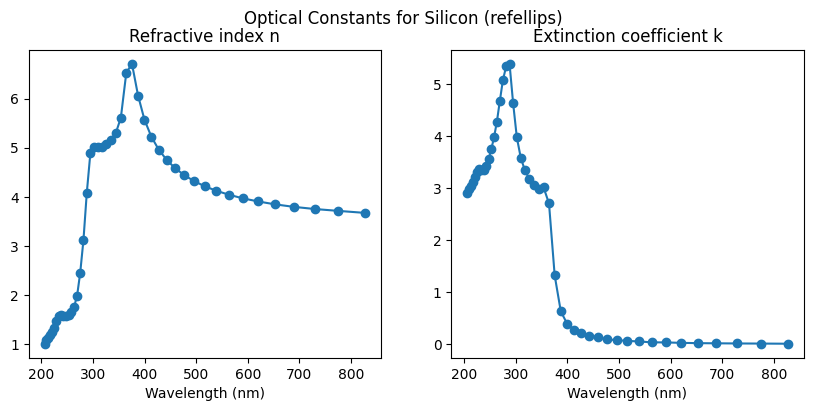

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(vars(si)['_wav'], vars(si)['_RI'],'-o')
ax[1].plot(vars(si)['_wav'], vars(si)['_EC'],'-o')
ax[0].set_title('Refractive index n')
ax[1].set_title('Extinction coefficient k')

for a in ax:
  a.set_xlabel('Wavelength (nm)')

plt.suptitle('Optical Constants for Silicon (refellips)')

The next way to specify the refractive index is through the RI() method. Here, you will directly enter the optical constants for the material.

In [19]:
sio2 = RI([1.4563, 0])

In [20]:
vars(sio2)

{'name': '',
 'dispersive': True,
 'wavelength': 658,
 '_wav': None,
 '_RI': 1.4563,
 '_EC': 0}

Finally (for this example), we can specify a material's optical constants by specifying what dispersion equation it follows. Here, we will do this for a Cauchy model, in which $k = 0$ and  
$n = A + \frac{B}{\lambda^{2}} + \frac{C}{\lambda^{4}} $,  
Where $\lambda$ must be in $\mu m$.

In [21]:
PNIPAM = Cauchy(A=1.47, B=0.00495) # often, C is not used because it has such a small effect

In [ ]:
vars(PNIPAM)

{'name': '',
 'dispersive': True,
 'wavelength': 658,
 'A': Parameter(value=1.47, name=' - cauchy A', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 'B': Parameter(value=0.00495, name=' - cauchy B', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 'C': Parameter(value=0.0, name=' - cauchy C', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None),
 '_parameters': Parameters(data=[Parameter(value=1.47, name=' - cauchy A', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.00495, name=' - cauchy B', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name=' - cauchy C', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='')}

Because it is a continuous equation, we can compute the refractive index at any wavelength for this material. Let's, for example, plot it out for 200-850 nm (note that the Cauchy equation requires the wavelengths in microns):

Text(0, 0.5, 'n (unitless)')

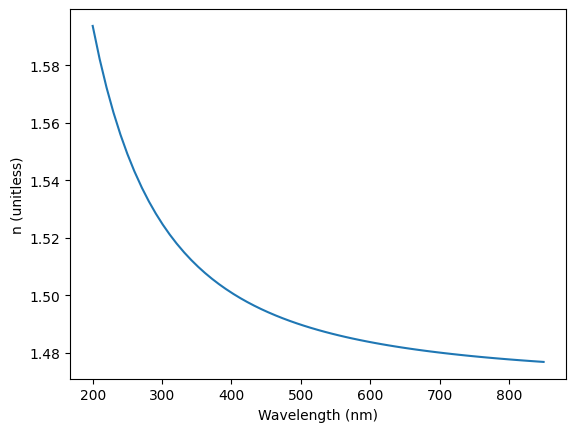

In [51]:
wls = 10**-3*np.linspace(200, 850, num=(int((850-200)/10)),dtype=int)
def calcCauch(wl_um, A, B, C=0): # used a different name for the function because refellips already has something named "Cauchy"
  return A + B/(wl_um**2) + C/(wl_um**4)
plt.plot(wls*10**3,calcCauch(wls,A=1.47, B=0.00495))
plt.xlabel('Wavelength (nm)'); plt.ylabel('n (unitless)')

## Make "slabs" of the films we will need to model this.

When we have a film on top of a silicon substrate, there will typically be an oxide layer of SiO2 in between. On commercial wafers, this is generally assumed to be around 2 nm unless otherwise stated.

Initialize starting guesses for the thicknesses of the two layers which we want to find the thickness of. Note that units here are in $Å$.

In [52]:
silica_layer = sio2(20) # initialize using the material variables we defined earlier
polymer_layer = PNIPAM(200)

Next, we will turn on what parameters we want to fit for. Here, we have dry films, so vfsolv (volume fraction solvent) is set to 0. Roughness is also set to 0, though we haven't explicitly named it. The only thing we are fitting in these films is the thickness. Even though we are only trying to find the thickness of the PNIPAM, there can be small variations in actual oxide thickness, so we need to fit that as well.

In [54]:
silica_layer.name = "Silica"
silica_layer.thick.setp(vary=True, bounds=(1, 30))
silica_layer.vfsolv.setp(vary=False, value=0)

polymer_layer.name = "PNIPAM"
polymer_layer.thick.setp(vary=True, bounds=(100, 500))
polymer_layer.vfsolv.setp(vary=False, value=0)

In [55]:
polymer_layer

SlabSE(Parameter(value=200.0, name=' - thick', vary=True, bounds=Interval(lb=100.0, ub=500.0), constraint=None), <refellips.dispersion.Cauchy object at 0x7d61ac86b3e0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='PNIPAM', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None)

Above, note that we set "vary=True" for the thicknesses of both, and then we specify upper bounds. For the SiO2, we are saying that it can hold possible values from 0.1 nm up to 3 nm, while the PNIPAM can be anywhere from 10 to 50 nm. This will require some prior knowledge of your system to set realistic bounds.

## Assemble the component slabs into a "structure"  
The | characters used in constructing the structure are interesting to me. I believe they are specific to this package, as I have never seen them used in any other code. The materials/slabs move top to bottom. Note that air is a continuous medium, so it doesn't have a thickness; Silicon is the substrate, and it is reflective, so it doesn't need a thickness either.

In [56]:
structure = air() | polymer_layer | silica_layer | si()

In [57]:
structure

Structure(components=[SlabSE(Parameter(value=0.0, name=' - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), <refellips.dispersion.RI object at 0x7d61adcbbfb0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=200.0, name=' - thick', vary=True, bounds=Interval(lb=100.0, ub=500.0), constraint=None), <refellips.dispersion.Cauchy object at 0x7d61ac86b3e0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='PNIPAM', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=20.0, name=' - thick', vary=True, bounds=Interval(lb=1.0, ub=30.0), constraint=None), <refellips.dispersion.R

## Make a model
This step may seem redundant, but it transforms the structure into an object that, code-wise, can be used for further fitting.

In [58]:
model = ReflectModelSE(structure)

In [59]:
model

ReflectModel(Structure(components=[SlabSE(Parameter(value=0.0, name=' - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), <refellips.dispersion.RI object at 0x7d61adcbbfb0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=200.0, name=' - thick', vary=True, bounds=Interval(lb=100.0, ub=500.0), constraint=None), <refellips.dispersion.Cauchy object at 0x7d61ac86b3e0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='PNIPAM', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=20.0, name=' - thick', vary=True, bounds=Interval(lb=1.0, ub=30.0), constraint=None), <refellips

"Delta offset" is an instrumental error parameter. This would be a constant value for your particular instrument. It would ideally be found by running a control sample first, such as a bare piece of silicon, and then be fixed in your model. Here it is set to 0 and fixed.

In [61]:
model.delta_offset.setp(value=0, vary=False)

Let's see what we have before we perform the fitting. The individual symbols are the experimental values for psi and delta; the lines (which have 4 points) are what the simulated psi and delta would look like at the currently-specified film parameters.

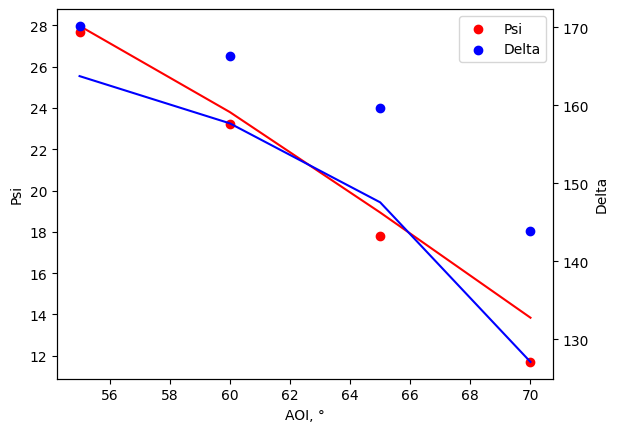

In [66]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50, 75, 100)

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]

    psi, delta = model(wavelength_aois)
    ax.plot(aois, psi, color="r")
    p = ax.scatter(data.aoi, data.psi, color="r")

    axt.plot(aois, delta, color="b")
    d = axt.scatter(data.aoi, data.delta,color="b")

ax.legend(handles=[p, d], labels=["Psi", "Delta"])
ax.set(ylabel="Psi", xlabel="AOI, °")
axt.set(ylabel="Delta")
plt.show()

## Combine the model with the function
This will essentially just wrap the model with the data, so that this singular object can be optimized.

In [67]:
objective = ObjectiveSE(model,data)

In [68]:
objective

Objective(ReflectModel(Structure(components=[SlabSE(Parameter(value=0.0, name=' - thick', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), <refellips.dispersion.RI object at 0x7d61adcbbfb0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=200.0, name=' - thick', vary=True, bounds=Interval(lb=100.0, ub=500.0), constraint=None), <refellips.dispersion.Cauchy object at 0x7d61ac86b3e0>, Parameter(value=0.0, name=' - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), name='PNIPAM', vfsolv=Parameter(value=0.0, name=' - volfrac solvent', vary=False, bounds=Interval(lb=0.0, ub=1.0), constraint=None), interface=None), SlabSE(Parameter(value=20.0, name=' - thick', vary=True, bounds=Interval(lb=1.0, ub=30.0), constraint=None), 

## Finally, fit the data.

In [69]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares")

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 8.311e-02  1.380e-01  2.394e-01  5.105e-02  1.800e-01
                1.402e-01  8.344e-02  1.903e-01]
           x: [ 1.323e+02  1.000e+00]
        cost: 0.09055641524849325
         jac: [[ 1.659e-03  1.675e-03]
               [ 3.638e-03  3.620e-03]
               ...
               [ 1.450e-01  1.415e-01]
               [-2.257e-01 -2.202e-01]]
        grad: [ 2.397e-09  6.123e-05]
  optimality: 7.750069914670909e-08
 active_mask: [ 0 -1]
        nfev: 11
        njev: 10
       covar: [[ 9.652e+05 -9.891e+05]
               [-9.891e+05  1.014e+06]]
      stderr: [ 9.825e+02  1.007e+03]

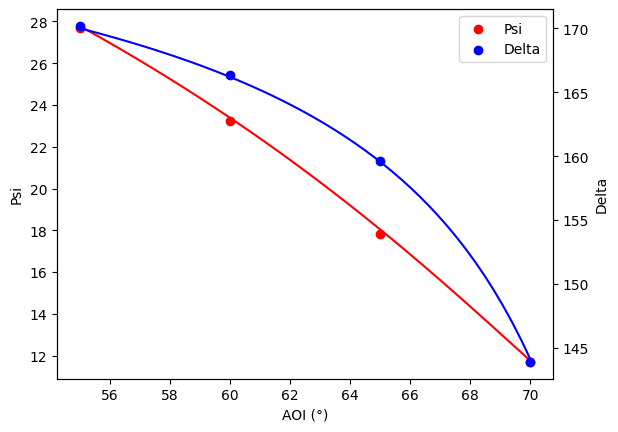

In [70]:
fig, ax = objective.plot()

In [71]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'PNIPAM'    
<Parameter:  ' - thick'   , value=132.339  +/- 982 , bounds=[100.0, 500.0]>
<Parameter: ' - cauchy A' , value=1.47  (fixed) , bounds=[-inf, inf]>
<Parameter: ' - cauchy B' , value=0.00495  (fixed) , bounds=[-inf, inf]>
<Parameter: ' - cauchy C' , value=0  (fixed) , bounds=[-inf, inf]